In [4]:
%load_ext autoreload
%autoreload 2

import scipy
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import random
import sir_model
import json
from random import randint
import itertools
import datetime
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def query_1(sim, tstart, tend, dt):
    S, I, D, A, R, T, H, E = sim.T

    # USER: write query condition.
    # query_condition =  0.15 <= max(I) <= 0.3  #((0.15 <= I[10]) and I[10] <= 1.0)
    # query_condition = (0.45 <= max(I)) and (max(I) <= 0.55) and (45 <= np.argmax(I)*dt) and (np.argmax(I)*dt <= 55)
    query_values = [0.45 <= I[int(t/dt)] <= 0.55 for t in range(tstart, tend+1, dt) if 45 <= t < 55]
    query_condition = all(query_values) 
    # print(I[9:11])
    return query_condition

def query_2(sim, tstart, tend, dt):
    S, I, D, A, R, T, H, E = sim.T

    # USER: write query condition.
    # query_condition =  0.15 <= max(I) <= 0.3  #((0.15 <= I[10]) and I[10] <= 1.0)
    # query_condition = (0.45 <= max(I)) and (max(I) <= 0.55) and (45 <= np.argmax(I)*dt) and (np.argmax(I)*dt <= 55)
    query_values = [0.25 <= I[int(t/dt)] <= 0.55 for t in range(tstart, tend+1, dt) if 45 <= t < 55]
    query_condition = all(query_values) 
    # print(I[9:11])
    return query_condition

def eval_point(beta_val, lamb_val, query_condition=query_1, plot=False, rtol=1, atol=1, mxstep=10, mxordn = 1, mxords=1, hmin=1):    
    # set parameters

    # USER: set values for all parameters that you are not synthesizing 
    alpha_val = 0.1 # I -> I
    delta_val = 0.00011 # S, R -> I

    epsilon_val = 0.03 # I -> D
    theta_val = 0.571 # A -> R

    zeta_val = 0.0125 # I -> A
    eta_val = 0.0125 # D -> R

    mu_val = 0.017 # A -> T
    nu_val = 0.027 # R -> T
    gamma_val = 0.0456 # S, A -> I
    rho_val = 0.034 # D -> H

    kappa_val = 0.017 # A -> H
    xi_val = 0.017 # R -> H
    sigma_val = 0.017 # T -> H
    
    tau_val = 0.01 # T -> E

    # USER: set initial conditions
    I0, D0, A0, R0, T0, H0, E0 = 0.01, 0, 0, 0, 0, 0, 0
    S0 = 1-I0-D0-A0-R0-T0-H0-E0

    # USER: set simulation parameters
    dt = 1
    tstart = 0
    tend = 100

    # parameters
    # set parameter values
    def alpha(t): return np.piecewise(t, [t>=0], [alpha_val])
    def beta(t): return np.piecewise(t, [t>=0], [beta_val])
    def delta(t): return np.piecewise(t, [t>=0], [delta_val])
    def gamma(t): return np.piecewise(t, [t>=0], [gamma_val])

    def epsilon(t): return np.piecewise(t, [t>=0], [epsilon_val])
    def theta(t): return np.piecewise(t, [t>=0], [theta_val])

    def zeta(t): return np.piecewise(t, [t>=0], [zeta_val])
    def eta(t): return np.piecewise(t, [t>=0], [eta_val])

    def mu(t): return np.piecewise(t, [t>=0], [mu_val])
    def nu(t): return np.piecewise(t, [t>=0], [nu_val])
    def lamb(t): return np.piecewise(t, [t>=0], [lamb_val])
    def rho(t): return np.piecewise(t, [t>=0], [rho_val])

    def kappa(t): return np.piecewise(t, [t>=0], [kappa_val])
    def xi(t): return np.piecewise(t, [t>=0], [xi_val])
    def sigma(t): return np.piecewise(t, [t>=0], [sigma_val])

    def tau(t): return np.piecewise(t, [t>=0], [tau_val])

    y0 = S0, I0, D0, A0, R0, T0, H0, E0 # Initial conditions vector

    tvect = np.arange(tstart, tend, dt)
    # simulate/solve ODEs
    sim = odeint(sir_model.SIDARTHE_model, y0, tvect, args=(alpha, beta, gamma, delta, epsilon, mu, zeta, lamb, eta, rho, theta, kappa, nu, xi, sigma, tau))
    S, I, D, A, R, T, H, E = sim.T


    # write query condition.
    # query_condition = (0.999 <= (S+I+D+A+R+T+H+E).all() <= 1.001)  # compartmental constraint
    #query_condition =  (0.32 <= max(I) <= 0.33) and (12 <= np.argmax(I)*dt <= 14) # max location and size
    query = '1' if query_condition(sim, tstart, tend, dt) else '0'
    # plot results - uncomment next line to plot time series.  not recommended for large numbers of points
    # if query == '1':
    #     print('beta:', beta_val, 'gamma:', gamma_val)
    if plot:
        sir_model.plotSIDARTHE(tvect, S, I, D, A, R, T, H, E)
    ## end plot
    param_assignments = {'beta': beta_val, 'lambda': lamb_val, 'assignment': query} # for "all", go through every option. for "any", only need one good parameter choice.
    return param_assignments, sim
    
# set parameters
def ps(param_synth_method, parameter_search_bounds, query_condition=query_1, rtol=1e-3, num_dim_points=10, plot=False):
    parameters = list(parameter_search_bounds.keys())
    parameter_points = {p : np.linspace(parameter_search_bounds[p][0], parameter_search_bounds[p][1], num_dim_points) for p in parameters}
    points = itertools.product(*[parameter_points[p] for p in parameters])
    param_choices_true_false = []
    coverage = []
    
    for i, point in enumerate(points):
        point_values = {p: point[i] for i, p in enumerate(parameters)}
        
        param_assignments, _ = eval_point(point_values["beta"], point_values["lambda"], query_condition=query_condition, rtol=rtol, plot=plot)
        param_choices_true_false.append(param_assignments)
        coverage.append((datetime.datetime.now(), i))
        
        if param_synth_method == "any" and param_assignments['assignment'] == '1':
            return param_choices_true_false, coverage
    return param_choices_true_false, coverage




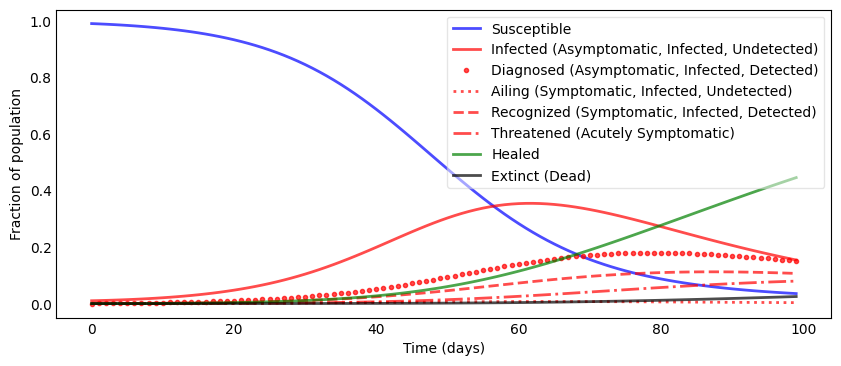

[{'beta': 0.15510204081632656, 'lambda': 0.0, 'assignment': '1'}]


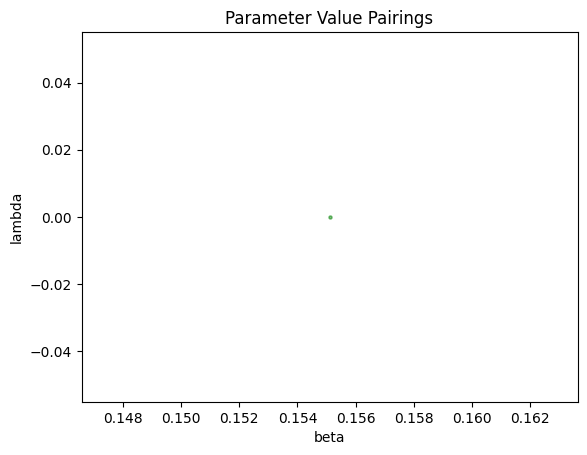

In [9]:
# Consistency Query

# USER: set num_dim_points with how many points for each parameter you'd like to evaluate

# USER: set bounds
beta_search_bounds = [0.15510204081632656, 0.15510204081632656] #[0.008,0.01] # S, D -> I
lambda_search_bounds = [0.000, 0.0] #[0.36,0.55] # I -> H


param_choices_true_false, coverage = ps("any", {"beta": beta_search_bounds, "lambda": lambda_search_bounds}, query_condition=query_2, rtol=1e-3, num_dim_points=1, plot=True)
print(param_choices_true_false)

# id_number = randint(10**5, 10**6 - 1)
# with open(f'sir_query_auto_2_param_{id_number}.json', 'w', encoding='utf-8') as f:
#     json.dump(param_choices_true_false, f, ensure_ascii=False, indent=4)

# Plot "true/false" points.  
sir_model.plot_two_params("beta", "lambda", param_choices_true_false)


{'beta': 0.15510204081632656, 'lambda': 0.0, 'assignment': '1'}


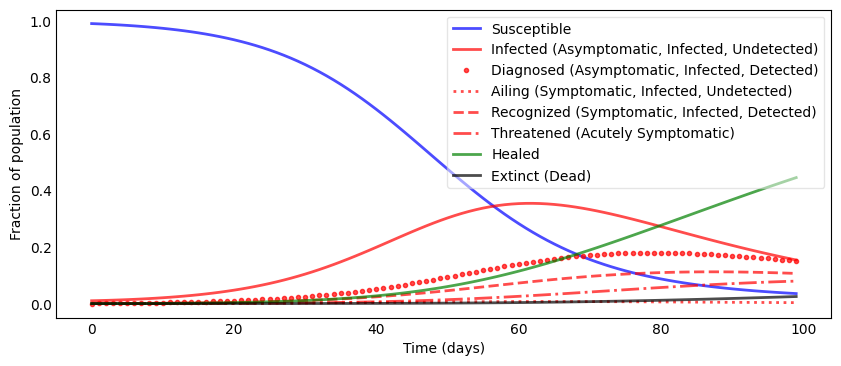

In [8]:
# Parameterization

# USER: set num_dim_points with how many points for each parameter you'd like to evaluate

# USER: set bounds
beta_search_bounds = [0.1, 1] #[0.008,0.01] # S, D -> I
lambda_search_bounds = [0.000, 0.1] #[0.36,0.55] # I -> H


num_dim_points = 50

param_choices_true_false, coverage = ps("any", {"beta": beta_search_bounds, "lambda": lambda_search_bounds}, query_condition=query_2, rtol=1e-3,  num_dim_points=num_dim_points)
# print(param_choices_true_false)

# id_number = randint(10**5, 10**6 - 1)
# with open(f'sir_query_auto_2_param_{id_number}.json', 'w', encoding='utf-8') as f:
#     json.dump(param_choices_true_false, f, ensure_ascii=False, indent=4)

solutions = [p for p in param_choices_true_false if p['assignment']=="1"]
if len(solutions) > 0:
    my_params = solutions[0]
    print(my_params)
    param_assignment, sim = eval_point(my_params["beta"], my_params["lambda"], plot=True, mxstep=20, query_condition=query_2)
else:
    print("No solutions!")

In [11]:
# Parameter Synthesis

# USER: set num_dim_points with how many points for each parameter you'd like to evaluate
num_points = 10

# USER: set bounds
beta_search_bounds = [0.1, 1] #[0.008,0.01] # S, D -> I
lambda_search_bounds = [0.000, 0.1] #[0.36,0.55] # I -> H


param_choices_true_false, coverage = ps("all", {"beta": beta_search_bounds, "lambda": lambda_search_bounds}, query_condition=query_2, rtol=1e-3,  num_dim_points=num_dim_points)
# print(param_choices_true_false)

# id_number = randint(10**5, 10**6 - 1)
# with open(f'sir_query_auto_2_param_{id_number}.json', 'w', encoding='utf-8') as f:
#     json.dump(param_choices_true_false, f, ensure_ascii=False, indent=4)


# Plot "true/false" points.  Is there any way of characterizing these regions?
sir_model.plot_two_params("gamma", "lambda", param_choices_true_false)
